In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.nn import Mish
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from typing import Tuple, List, Type, Dict, Any

In [ ]:
import urllib.request

In [5]:
def one_hot(arr):
    classes = np.unique(arr)
    num_classes = len(classes)
    return classes, np.squeeze(np.eye(num_classes)[arr.reshape(-1)])

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def md5(fname):
    import hashlib
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def show_progress(block_num, block_size, total_size):
    print(round(block_num * block_size / total_size *100,2), end="\r")

In [ ]:
mnist_data_hash = '84badc3964f15cbf97e9d0cba7f8e6d6'
mnist_labels_hash = 'c17778ef9af07481b34bc3ca84d9b21a'

In [ ]:
if not os.path.exists('mnist_data.npy'):
    print('downloading MNIST data:')
    urllib.request.urlretrieve("https://ml4es.ru/links/mnist-data", "mnist_data.npy", show_progress)
downloaded_mnist_data_hash = md5('./mnist_data.npy')
assert downloaded_mnist_data_hash == mnist_data_hash, 'Downloaded MNIST data is corrupt. Try downloading again.'
print('MNIST data is valid')

if not os.path.exists('mnist_labels.npy'):
    print('downloading MNIST labels:')
    urllib.request.urlretrieve("https://ml4es.ru/links/mnist-labels", "mnist_labels.npy", show_progress)
downloaded_mnist_labels_hash = md5('./mnist_labels.npy')
assert downloaded_mnist_labels_hash == mnist_labels_hash, 'Downloaded MNIST labels is corrupt. Try downloading again.'
print('MNIST labels are valid')

In [6]:
X = np.load('./mnist_data.npy')
y = np.load('./mnist_labels.npy')

In [7]:
X.shape, y.shape

((70000, 784), (70000,))

In [8]:
X = X.reshape((X.shape[0], 28, 28))

In [9]:
classes,y = one_hot(y)

In [10]:
X.shape, y.shape

((70000, 28, 28), (70000, 10))

In [20]:
y[:7]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [21]:
y[:7].shape

(7, 10)

In [12]:
X = (X/255.).astype(np.float32)

In [17]:
random_index = np.random.randint(0, X.shape[0], 1)
random_digit = X[random_index]

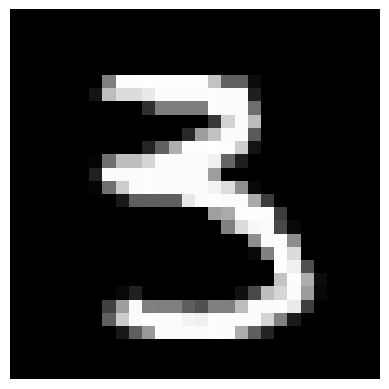

In [18]:
plt.imshow(np.squeeze(random_digit), cmap='gray')
_ = plt.axis('off')

In [22]:
class ConvNet(torch.nn.Module):
    
    def __init__(self, 
                 input_size = (28, 28),
                 conv_channels: List[int] = [8, 32, 64],
                 activation: Type[torch.nn.Module] = Mish):

        super().__init__()

        _conv_layers = []
        curr_channels = 1
        pool = torch.nn.MaxPool2d(kernel_size=(2,2))
        act = activation()
        
        for hidden_channels in conv_channels:
            conv = torch.nn.Conv2d(curr_channels,
                                   hidden_channels,
                                   kernel_size=(3,3),
                                   stride=1,
                                   padding=1,
                                   padding_mode='zeros')
            _conv_layers.append(conv)
            _conv_layers.append(act)
            _conv_layers.append(pool)
            curr_channels = hidden_channels
            
        # 1  x 28x28 -> (conv) -> 8  x 28x28 -> (act) -> (pool) -> 8  x 14x14
        # 8  x 14x14 -> (conv) -> 32 x 14x14 -> (act) -> (pool) -> 32 x 7x7
        # 32 x 7x7   -> (conv) -> 64 x 7x7   -> (act) -> (pool) -> 64 x 3x3
        
        gap = torch.nn.AvgPool2d(kernel_size=(3,3))
        # N x 64 x 3x3 -> (pool) -> N x 64 x 1x1
        
        _conv_layers.append(gap)
        
        _fc_layers = []
        _fc_layers.append(torch.nn.Linear(64, 32))
        _fc_layers.append(act)
        _fc_layers.append(torch.nn.Linear(32, 16))
        _fc_layers.append(act)
        _fc_layers.append(torch.nn.Linear(16, 10))
#         _fc_layers.append(act)
#         _fc_layers.append(torch.nn.Identity())
        
        # N x 10
        _fc_layers.append(torch.nn.Softmax(dim=-1))
        
        self._conv_layers = torch.nn.Sequential(*_conv_layers)
        self._fc_layers = torch.nn.Sequential(*_fc_layers)
    
    def forward(self, x):
        h = self._conv_layers.forward(x)
        x = torch.flatten(h, start_dim=1)
        # N x 64 x 1x1 -> (flatten) -> N x 64
        
        out = self._fc_layers.forward(x)
        return out

In [23]:
model = ConvNet()

In [24]:
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

ConvNet(
  (_conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Mish()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Mish()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): AvgPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0)
  )
  (_fc_layers): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Mish()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Mish()
    (4): Linear(in_features=16, out_features=10, bias=True)
    (5): Softmax(dim=-1)
  )
)
Total number of trainable parameters 23690


In [25]:
model = model.cuda()

In [26]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader,
                       tb_writer: SummaryWriter,
                       epoch: int,
                       batch_size: int,
                       epoch_size_batches: int):
    train_loss = []
    batch_averaged_loss = []
    idx = 0
    model.train()
    while True:
        (batch_data, batch_labels) = next(iter(data_loader))
        optimizer.zero_grad()
        data_gpu, labels_gpu = batch_data.cuda(), batch_labels.cuda()
        output = model(data_gpu)
        loss = loss_function(output, labels_gpu)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        idx = idx + 1
        if idx >= epoch_size_batches:
            break
    return train_loss

In [27]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data_gpu, labels_gpu = data.cuda(), labels.cuda()
            output = model(data_gpu)
            test_loss += loss_function(output, labels_gpu).sum()

    return {'loss': test_loss.item() / len(data_loader.dataset)}

In [34]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None, transform_labels = None):
        self.X = X
        self.transform = transform
        self.Y = y
        self.transform_labels = transform_labels

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx, ...]
        # X: N x 28x28
        # x: 28x28
        
        x = x[np.newaxis,...]
        # -> x: 1 x 28x28
        
        # DataLoader: 64 x 1x28x28
        # data (x) : NxCxHxW
        
        y = self.Y[idx, ...]
        # 10
        # DataLoader: 10 -> Nx10
        
        if self.transform:
            x = self.transform(x)
        if self.transform_labels:
            y = self.transform_labels(y)
        return x, y

In [35]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=10000)

In [36]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((60000, 28, 28), (10000, 28, 28), (60000, 10), (10000, 10))

In [37]:
train_dataset = CustomDataset(x_train, y_train)

In [38]:
val_dataset = CustomDataset(x_val, y_val)

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [40]:
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [41]:
xbatch, ybatch = next(iter(train_dataloader))

## ВНИМАНИЕ!!!

обратить внимание на размерность мини-батча признакового описания объектов

In [44]:
xbatch.shape

# Соглашение в Pytorch: признаковое описание примеров поставляется в формате NCHW:
# N - нумерует экземпляры (примеры) в подмножестве данных
# C - количество цветовых каналов (признаков) во входных данных или в картах активаций
# H - высота по пространственным размерностям - кол-во строк
# W - ширина по пространственным размерностям - кол-во столбцов

torch.Size([64, 1, 28, 28])

In [45]:
ybatch.shape

torch.Size([64, 10])

In [46]:
ybatch_pred = model(xbatch.cuda())

In [47]:
ybatch_pred.shape

torch.Size([64, 10])

In [48]:
ybatch_pred

tensor([[0.0852, 0.1075, 0.1144, 0.0813, 0.1105, 0.0791, 0.1051, 0.0958, 0.1264,
         0.0947],
        [0.0853, 0.1074, 0.1143, 0.0812, 0.1106, 0.0792, 0.1052, 0.0957, 0.1265,
         0.0947],
        [0.0853, 0.1074, 0.1144, 0.0812, 0.1105, 0.0791, 0.1051, 0.0957, 0.1264,
         0.0948],
        [0.0852, 0.1074, 0.1144, 0.0813, 0.1105, 0.0791, 0.1051, 0.0957, 0.1265,
         0.0947],
        [0.0852, 0.1074, 0.1144, 0.0813, 0.1105, 0.0791, 0.1051, 0.0957, 0.1265,
         0.0948],
        [0.0853, 0.1074, 0.1144, 0.0813, 0.1105, 0.0792, 0.1051, 0.0957, 0.1264,
         0.0947],
        [0.0852, 0.1074, 0.1144, 0.0813, 0.1105, 0.0791, 0.1051, 0.0958, 0.1265,
         0.0947],
        [0.0853, 0.1074, 0.1143, 0.0812, 0.1105, 0.0792, 0.1051, 0.0957, 0.1265,
         0.0947],
        [0.0852, 0.1074, 0.1144, 0.0813, 0.1105, 0.0792, 0.1051, 0.0957, 0.1265,
         0.0947],
        [0.0853, 0.1074, 0.1144, 0.0813, 0.1105, 0.0791, 0.1051, 0.0957, 0.1265,
         0.0947],
        [0

In [49]:
loss_fn = torch.nn.CrossEntropyLoss()

In [50]:
loss_fn(ybatch_pred, ybatch.cuda())

tensor(2.3024, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)

In [52]:
def train_model(run_name: str,
                model: torch.nn.Module, 
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_function: torch.nn.Module = torch.nn.MSELoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.001,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                max_epochs = 1000,
                early_stopping_patience = 10):
    
    #region TENSORBOARD tutorial
    tb_writer = SummaryWriter(log_dir=f'./logs/{run_name}/')
    #endregion ##############################
    
    #region borrowed from HW03
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    best_test_loss = None
    best_epoch = None
    
    loss_history = []
    #endregion borrowed from HW03
    
    pbar = tqdm(total=max_epochs)
    for epoch in range(max_epochs):
        train_epoch_loss_history = train_single_epoch(model,
                                                      optimizer,
                                                      loss_function,
                                                      train_dataloader,
                                                      tb_writer,
                                                      epoch,
                                                      batch_size=train_dataloader.batch_size,
                                                      epoch_size_batches=156)
        loss_history = loss_history + train_epoch_loss_history
        test_metrics = validate_single_epoch(model,
                                             loss_function,
                                             test_dataloader)
        
        #region TENSORBOARD logging
        tb_writer.add_scalar('train_loss',
                             np.sum(train_epoch_loss_history)/len(train_dataloader.dataset),
                             global_step=epoch)
        tb_writer.add_scalar('val_loss', test_metrics['loss'], global_step=epoch)
        #endregion ##############################
        
        lr_scheduler.step(test_metrics['loss'])
        
        if best_test_loss is None or best_test_loss > test_metrics['loss']:
            best_test_loss = test_metrics['loss']
            best_epoch = epoch
            torch.save(model, f'./best_model_{run_name}.pth')
        
        pbar.update(1)
        pbar.set_postfix(ordered_dict={'val_loss': test_metrics['loss']})
        #endregion ##############################

In [53]:
train_model('run002',
            model, 
            train_dataloader = train_dataloader,
            test_dataloader = val_dataloader,
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.0001,
            max_epochs=100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it, val_loss=0.0254]


### Применим нейросеть на одном подмножестве (mini-batch) данных

In [82]:
loss_function = torch.nn.CrossEntropyLoss()

In [83]:
model = model.cpu()

In [84]:
x,y = next(iter(val_dataloader))

In [85]:
x.shape

torch.Size([64, 1, 28, 28])

In [86]:
y.shape

torch.Size([64, 10])

In [87]:
y_prime = model(x)

In [88]:
y[1,:]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=torch.float64)

In [89]:
y_prime[1,:]

tensor([1.2304e-06, 2.9454e-10, 9.4713e-07, 1.4101e-14, 1.7952e-05, 2.5333e-08,
        9.9995e-01, 1.1408e-18, 2.8187e-05, 3.2945e-21],
       grad_fn=<SliceBackward0>)

In [90]:
loss_function(y_prime, y)/len(y)

tensor(0.0257, dtype=torch.float64, grad_fn=<DivBackward0>)

In [92]:
output_class = torch.argmax(y_prime, dim=1)

In [93]:
output_class

tensor([4, 6, 2, 6, 2, 1, 7, 1, 4, 3, 4, 1, 6, 5, 8, 8, 7, 0, 5, 8, 6, 5, 2, 6,
        6, 4, 2, 5, 1, 8, 0, 6, 5, 2, 7, 2, 7, 8, 4, 8, 3, 6, 7, 1, 8, 1, 3, 2,
        4, 5, 2, 4, 8, 2, 7, 2, 6, 0, 6, 2, 3, 3, 2, 3])

In [94]:
true_class = torch.argmax(y, dim=1)
true_class

tensor([9, 6, 2, 6, 2, 1, 7, 1, 9, 5, 4, 1, 6, 5, 8, 8, 7, 0, 5, 8, 6, 5, 2, 6,
        6, 4, 2, 5, 1, 8, 0, 6, 5, 2, 9, 9, 9, 8, 9, 3, 3, 6, 7, 1, 8, 1, 3, 2,
        9, 5, 2, 4, 9, 2, 9, 2, 6, 0, 6, 2, 1, 3, 2, 3])

In [95]:
(true_class == output_class).sum()/true_class.shape[0]

tensor(0.8125)

### Посчитаем долю верных ответов на всем валидационном подмножестве данных

In [96]:
model = model.cuda()

In [97]:
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [98]:
correct = 0
examples_num = 0
model.eval()
x_batches_test = []
y_batches_test = []
test_loss = 0
with torch.no_grad():
    for x,y in tqdm(val_dataloader, total = len(val_dataset)//64):
        x_batches_test.append(x.detach().cpu().numpy())
        y_batches_test.append(y.detach().cpu().numpy())
        x_gpu, y_gpu = x.cuda(), y.cuda()
        output_gpu = model(x_gpu)
        output_cpu = output_gpu.cpu()
        predicted_class = torch.argmax(output_cpu, dim=1)
        true_class = torch.argmax(y, dim=1)
        correct = correct + ((true_class == predicted_class).sum()).cpu().detach().numpy()
        examples_num = examples_num + float(x.shape[0])
        test_loss += loss_function(output_gpu, y_gpu).sum()

157it [00:00, 506.20it/s]                                                                                                                                                                                         


In [99]:
val_loss = test_loss/examples_num
val_loss.detach().cpu().numpy()

array(0.02535987)

In [100]:
val_accuracy = correct/examples_num
val_accuracy

0.8501